#Packages

In [17]:
import torch
import torch.nn as nn
import functools
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torch.nn.utils
from torch.autograd import Function
import torchvision.transforms as transforms

import time
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [26]:
#Set device to GPU_indx if GPU is avaliable
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')

# Their Resnet Model

In [3]:
class GenderClassification(nn.Module):

    def __init__(self):

        super(GenderClassification, self).__init__()
        print("Build a GenderClassification Model")

        self.base_network = models.resnet18(pretrained = True)
        print('Load weights from Resnet18 done')

        self.finalLayer = nn.Linear(self.base_network.fc.in_features, 2)

    def forward(self, image):
        x = self.base_network.conv1(image) 
        x = self.base_network.bn1(x) 
        x = self.base_network.relu(x) 
        x = self.base_network.maxpool(x) 

        x = self.base_network.layer1(x)
        x = self.base_network.layer2(x)
        x = self.base_network.layer3(x)
        x = self.base_network.layer4(x)

        x = self.base_network.avgpool(x)
        image_features = x.view(x.size(0), -1)

        preds = self.finalLayer(image_features)

        return preds

In [4]:
gender_classifier1 = GenderClassification()

Build a GenderClassification Model
Load weights from Resnet18 done


# Easy Resnet Model

In [7]:
gender_classifier2 = models.resnet18(pretrained=True)
input_feat = gender_classifier2.fc.in_features
gender_classifier2.fc = nn.Linear(in_features = input_feat, out_features = 2, bias = True)

# Parameters

In [22]:
num_epochs = 100

lr = 0.05
optimizer = optim.Adam(gender_classifier2.parameters(), lr=lr, weight_decay = 1e-5)
loss_fun = torch.nn.CrossEntropyLoss() # F.cross_entropy(adv_pred, genders.cuda().max(1, keepdim=False)[1], reduction='elementwise_mean')

# Train

In [13]:
def train(net, device, loader, optimizer, loss_fun):
    
    #initialise counters
    epoch_loss = 0
    
    #Set Network in train mode
    net.train()
    
    for i, (x, y) in enumerate(loader):
        
        #load images and labels to device
        x = x.to(device) # x is the image
        y = y.to(device) # y is the corresponding label
                
        #Forward pass of image through network and get output
        fx = net(x)
        
        #Calculate loss using loss function
        loss = loss_fun(fx, y)

        #Zero Gradents
        optimizer.zero_grad()
        #Backpropagate Gradents
        loss.backward()
        #Do a single optimization step
        optimizer.step()
        
        #create the cumulative sum of the loss and acc
        epoch_loss += loss.item()
        #log the loss for plotting

    epoch_loss /=  len(loader)
        
    #return the average loss from the epoch as well as the logger array       
    return epoch_loss

# Test

In [14]:
def evaluate(net, device, loader, loss_fun):
    
    epoch_loss = 0
    epoch_acc = 0
    
    #Set network in evaluation mode
    #Layers like Dropout will be disabled
    #Layers like Batchnorm will stop calculating running mean and standard deviation
    #and use current stored values
    net.eval()
    
    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            
            #load images and labels to device
            x = x.to(device)
            y = y.to(device)
            
            #Forward pass of image through network
            fx = net(x)
            
            #Calculate loss using loss function
            loss = loss_fun(fx, y)
            
            #calculate the accuracy
            epoch_acc += (fx.argmax(1) == y).sum().item()
            
            #log the cumulative sum of the loss
            epoch_loss += loss.item()
            
    epoch_loss /=  len(loader)
    epoch_acc /=  len(loader.dataset)

    #return the average loss and acc from the epoch as well as the logger array       
    return epoch_loss, epoch_acc

# Learning Scheduler from lab 7

In [ ]:
#Create a function that will linearly decay the learning rate every epoch
def lr_linear_decay(epoch_max, epoch, lr):
    lr_adj = ((epoch_max - epoch)/epoch_max)*lr
    #update the learning rate parameter of the optimizer
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr_adj

# Run the Training

In [15]:
#Log the training and validation losses
training_loss_logger = []
validation_loss_logger = []
#Log the training and validation losses
training_acc_logger = []
validation_acc_logger = []

In [27]:
#This cell implements our training loop

#Record the start time
Start_time = time.time()

for epoch in range(num_epochs):
    #Implement the linear decay of the learning rate
    #lr_linear_decay(num_epochs, epoch, learning_rate)
    
    #call the training function and pass training dataloader etc
    train_loss = train(gender_classifier2, device, train_loader, optimizer, loss_fun)
    
    #call the evaluate function and pass validation/training dataloader etc
    _, train_acc = evaluate(res_net, device, train_loader, loss_fun)
    valid_loss, valid_acc = evaluate(res_net, device, valid_loader, loss_fun)
    
    training_loss_logger.append(train_loss)
    validation_loss_logger.append(valid_loss)
    
    training_acc_logger.append(train_acc)
    validation_acc_logger.append(valid_acc)
    #If this model has the highest performace on the validation set 
    #then save a checkpoint
    #{} define a dictionary, each entry of the dictionary is indexed with a string
    if (valid_acc > best_valid_acc):
        best_valid_acc = valid_acc
        if save_checkpoint:
            print("Saving Model")
            torch.save({
                'epoch':                 epoch,
                'model_state_dict':      res_net.state_dict(),
                'optimizer_state_dict':  optimizer.state_dict(), 
                'train_acc':             train_acc,
                'valid_acc':             valid_acc,
            }, save_path)
            
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:05.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:05.2f}% |')

End_time = time.time()

NameError: ignored

In [28]:
print("The highest validation accuracy was %.2f%%" %(best_valid_acc*100))

NameError: ignored

In [29]:
print("Training time %.2f seconds" %(End_time - Start_time))

NameError: ignored

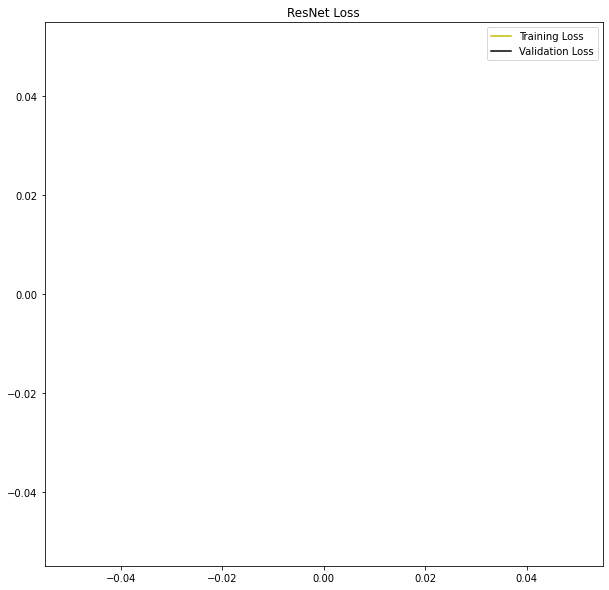

In [30]:
plt.figure(figsize = (10,10))
train_x = np.linspace(0, num_epochs, len(training_loss_logger))
plt.plot(train_x, training_loss_logger, c = "y")
valid_x = np.linspace(0, num_epochs, len(validation_loss_logger))
plt.plot(valid_x, validation_loss_logger, c = "k")

plt.title("ResNet Loss")
plt.legend(["Training Loss", "Validation Loss"])

In [ ]:
plt.figure(figsize = (10,10))
train_x = np.linspace(0, num_epochs, len(training_acc_logger))
plt.plot(train_x, training_acc_logger, c = "y")
valid_x = np.linspace(0, num_epochs, len(validation_acc_logger))
plt.plot(valid_x, validation_acc_logger, c = "k")

plt.title("ResNet Acc")
plt.legend(["Training Acc", "Validation Acc"])

# Evaluate

In [ ]:
#call the evaluate function and pass the evaluation/test dataloader etc
test_loss, test_acc = evaluate(res_net, device, test_loader, loss_fun)
print("Testing: | Loss %.2f | Accuracy %.2f%% |" %(test_loss, 100*test_acc))

# Stuff below was for me 
### - Old dataset types
### - Packages to install
### - Google mount

### Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive

[Errno 2] No such file or directory: 'drive/MyDrive'
/content/drive/MyDrive/Colab Notebooks/ECE4179/course proj


In [ ]:
cd Colab Notebooks

[Errno 2] No such file or directory: 'Colab Notebooks'
/content/drive/MyDrive/Colab Notebooks/ECE4179/course proj


In [ ]:
cd ECE4179

[Errno 2] No such file or directory: 'ECE4179'
/content/drive/MyDrive/Colab Notebooks/ECE4179/course proj


In [ ]:
cd course proj

[Errno 2] No such file or directory: 'course proj'
/content/drive/MyDrive/Colab Notebooks/ECE4179/course proj


In [ ]:
ls

age_gender.csv  Balanced_Set_Model.ipynb  GenderClassifier.ipynb


In [ ]:
train_transform = transforms.Compose(
        [transforms.Resize(args["image_size"]),
        transforms.RandomCrop(args["crop_size"]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
        ])

# Old Datasets: Celeb Face Dataset

In [15]:
# Packages for Datasets used below
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Image processing
from PIL import Image
import cv2

In [ ]:
imagenet_data = torchvision.datasets.ImageNet('course proj/img_align_celeba/')

data_loader = torch.utils.data.DataLoader(imagenet_data,
                                          batch_size=32,
                                          shuffle=True,
                                          num_workers=0)

RuntimeError: ignored

# Old DataSets: Gender DataSet

In [18]:
df = pd.read_csv('../course proj/age_gender.csv')

FileNotFoundError: ignored

In [19]:
print(f'Total Data Points: {df.shape[1]}')
print(f'Total columns/Features: {df.shape[0]}\n\n')
df.info()

NameError: ignored

In [ ]:
df['pixels'] = df['pixels'].apply(lambda x:  np.reshape(np.array(x.split(), dtype="float32"), (48,48)))

In [ ]:
df.gender.value_counts()

In [ ]:
#plot_data(rows=6, cols=7, lower_value=0, upper_value=len(df))

In [ ]:
class get_data(Dataset):
    def __init__(self, df):
        self.df = df
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=125.01632431478356, std=59.44005080507268)
        ])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,i):
        age = df['age'][i]
        eth = df['ethnicity'][i]
        gender = df['gender'][i]
        
        im = df['pixels'][i]
#         im = np.reshape(im, (48,48))
        im = self.transform(im)
        
        age = torch.tensor(age)
        eth = torch.tensor(eth)
        gender = torch.tensor(gender)
        
        return im, age, eth, gender

In [ ]:
train, test = train_test_split(df, test_size=0.2, random_state=129) 

print(f'- Number of Datapoints in Training Set: {len(train)}')
print(f'- Number of Datapoints in Test Set: {len(test)}')

In [ ]:
SEED = 1

# CUDA?
use_cuda = torch.cuda.is_available()
print("CUDA Available:", use_cuda)

# For reproducibility
torch.manual_seed(SEED)

if use_cuda:
    torch.cuda.manual_seed(SEED)
    BATCH_SIZE=64
else:
    BATCH_SIZE=32
    
print('BATCH_SIZE:', BATCH_SIZE)

In [ ]:
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}


train_loader = DataLoader(get_data(train), batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = DataLoader(get_data(test), batch_size=BATCH_SIZE, shuffle=False, **kwargs)
image, age, eth, gender = next(iter(train_loader))
gender